In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv('gdrive/MyDrive/test_task/train.csv')

In [4]:
for num, name_class in enumerate(df.category.unique()):
  df.loc[df.category==name_class, 'class'] = num

In [5]:
df['text_lower'] = [w.lower() for w in df.text]

In [12]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import transformers
from transformers import AutoModel, BertTokenizerFast

In [13]:
device = torch.device("cpu")

In [14]:
train_text, test_text, train_labels, test_labels = train_test_split(df['text_lower'], df['class'], 
                                                                    random_state=2041, 
                                                                    test_size=0.3, 
                                                                    stratify=df['class'])

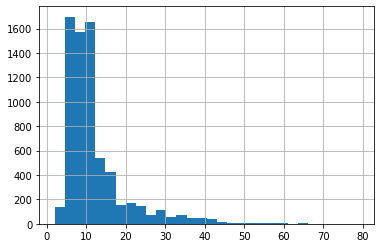

In [15]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [16]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# токенайзер 
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [17]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [19]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [21]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [22]:
for param in bert.parameters():
    param.requires_grad = False

In [23]:
n_class = len(df['class'].unique())

In [31]:
class classifier(nn.Module):

    def __init__(self, bert, n_features=768,  hid_size=512, n_class=n_class):
      
      super(classifier, self).__init__()

      self.bert = bert 
      self.linear = nn.Sequential(nn.Linear(n_features, hid_size*2), nn.ReLU(),  nn.Linear(hid_size*2, n_class))


    def forward(self, sent_id, mask):

      return self.linear(self.bert(sent_id, attention_mask=mask)['pooler_output'])

In [25]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)


In [35]:
weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device)

cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

In [36]:
from tqdm.notebook import tqdm
epoches = 4
total_loss, total_accuracy = 0, 0
model = classifier(bert=bert).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
total_preds=[]
total_loss, total_accuracy = 0, 0
for i in range(epoches):
  print('epoch = %s'%(i+1))
  model.train()
  for step, batch in enumerate(tqdm(train_dataloader)):
    if step % 50 == 0 and not step == 0:

  # push the batch to gpu
      batch = [r.to(device) for r in batch]

      sent_id, mask, labels = batch

      optimizer.zero_grad()        

      preds = model(sent_id, mask)
      labels = labels.long()
      loss = cross_entropy(preds, labels)
      print(loss.item())
      total_loss = total_loss + loss.item()

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()

      preds=preds.detach().cpu().numpy()

      #total_preds.append(preds)


  avg_loss = total_loss / len(train_dataloader)
    #total_preds  = np.concatenate(total_preds, axis=0)

epoch = 1


  0%|          | 0/219 [00:00<?, ?it/s]

4.35781717300415
4.329471111297607
4.3272705078125
4.373135566711426
epoch = 2


  0%|          | 0/219 [00:00<?, ?it/s]

4.341747283935547
4.401723384857178
4.329702377319336
4.353243350982666
epoch = 3


  0%|          | 0/219 [00:00<?, ?it/s]

4.368808746337891
4.333616733551025
4.38923454284668
4.335952281951904
epoch = 4


  0%|          | 0/219 [00:00<?, ?it/s]

4.373864650726318
4.371582984924316
4.355922698974609
4.355760097503662


In [34]:
from sklearn.metrics import f1_score
count = 0
f1 = []
for batch in test_dataloader:
  model.eval()
  batch = [r.to(device) for r in batch]
  count += 1
  sent_id, mask, labels = batch
  with torch.no_grad():
    pred = model(sent_id, mask)
    pred = torch.argmax(pred, dim=1).cpu().detach().numpy()
    f1.append(f1_score(pred, labels.cpu().detach().numpy(), pred, average='macro'))
print(sum(f1)/count)

0.019533292342565654
